In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Input, Flatten, Dense, Concatenate,Dropout
from keras.models import Model
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.utils import shuffle
import os
import random
import shutil
import time
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras import optimizers
from keras import backend
import warnings


In [ ]:
warnings.filterwarnings("ignore")

# This is utility functions for graph related operations

In [ ]:
def plot_graph(history) :
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

# This is utility functions for time related operations

In [ ]:
def print_time(start_time, end_time, description) :
    total_time_in_seconds = end_time - start_time
    total_time_in_minutes = total_time_in_seconds / 60
    print(description.format(total_time_in_minutes))

# This is utility functions for file and dataset related operations

In [ ]:
def get_save_path(filename, dataset_save_folder = '/kaggle/working/') :
    return os.path.join(dataset_save_folder, filename)

def create_dir(path_dir) :
    if not os.path.exists(path_dir) :
        os.makedirs(path_dir)

def generate_dataset(src_dir, dest_dir, image_set_number, validation_image_number = 24) :
    train_dir = os.path.join(dest_dir, 'train')
    test_dir = os.path.join(dest_dir, 'test')
    validation_dir = os.path.join(dest_dir, 'validation')
    
    create_dir(train_dir)
    create_dir(test_dir)
    create_dir(validation_dir)
    
    categories = os.listdir(src_dir)
    for category in categories:
        category_path = os.path.join(src_dir, category)
        
        category_train_path = os.path.join(train_dir, category)
        category_test_path = os.path.join(test_dir, category)
        category_validation_path = os.path.join(validation_dir, category)
        
        create_dir(category_train_path)
        create_dir(category_test_path)
        create_dir(category_validation_path)
        
        if os.path.isdir(category_path):
            image_files = os.listdir(category_path)
            random.shuffle(image_files)
            train_images = image_files[:image_set_number]
            test_images = image_files[image_set_number:]
            
            # Create test folder
            for filename in test_images:
                src = os.path.join(category_path, filename)
                dst = os.path.join(category_test_path, filename)
                shutil.copy(src, dst)
            
            train_set_images = train_images[:validation_image_number]
            validation_images = train_images[validation_image_number:]
            
            # Create validation folder
            for filename in validation_images:
                src = os.path.join(category_path, filename)
                dst = os.path.join(category_validation_path, filename)
                shutil.copy(src, dst)
                
            # Create train folder
            for filename in train_set_images:
                src = os.path.join(category_path, filename)
                dst = os.path.join(category_train_path, filename)
                shutil.copy(src, dst)

# Clasification Model


In [ ]:
def execute_model(training_data_set_folder, validation_data_set_folder, testing_data_set_folder, epochs = 50, batch_size = 32) :
    backend.clear_session()
    
    train_datagen = ImageDataGenerator(
          rescale=1./255,
          rotation_range=40,
          width_shift_range=0.2,
          height_shift_range=0.2,
          shear_range=0.2,
          zoom_range=0.2,
          horizontal_flip=True,
          fill_mode='nearest')

    train_generator = train_datagen.flow_from_directory(
            training_data_set_folder,
            target_size=input_size,
            batch_size=32,
            class_mode='categorical')

    test_datagen = ImageDataGenerator(rescale=1./255)
    validation_generator = test_datagen.flow_from_directory(
            validation_data_set_folder,
            target_size=input_size,
            batch_size=batch_size,
            class_mode='categorical')

    test_generator = test_datagen.flow_from_directory(
            testing_data_set_folder,
            target_size=input_size,
            batch_size=batch_size,
            class_mode='categorical')

    input_shape = Input(shape=input_size+(3,))
    start_time = time.time()
    
    vgg_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_shape)
    vgg_features = vgg_model.output
    vgg_features = Flatten()(vgg_features)
    vgg_features = Dense(512, activation='relu')(vgg_features)
    
    vgg_end_time = time.time()
    print_time(start_time,vgg_end_time, "Total time spend during feature extraction from the VGG16 model is {} minutes")
    
    resnet_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_shape)
    resnet_features = resnet_model.output
    resnet_features = Flatten()(resnet_features)
    resnet_features = Dense(512, activation='relu')(resnet_features)
    
    resnet_end_time = time.time()
    print_time(vgg_end_time,resnet_end_time, "Total time spend during feature extraction from the Resnet model is {} minutes")
    
    merged = Concatenate()([vgg_features, resnet_features])
    merged = Dropout(0.5)(merged)
    merged = Dense(256, activation='relu')(merged)
    merged = Dropout(0.5)(merged)
    predictions = Dense(train_generator.num_classes, activation='softmax')(merged)

    model = Model(inputs=input_shape, outputs=predictions)
    model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size)
    
    plot_graph(history)
    
    training_end_time = time.time()
    print_time(resnet_end_time,training_end_time, "Total time spend during training is {} minutes")
    
    testing_accuracy_tracker = []
    testing_losses_tracker = []
    for i in range(2) :
        testing_start_time = time.time()
        loss, accuracy = model.evaluate_generator(test_generator, steps= test_generator.samples // batch_size)
        testing_accuracy_tracker.append(accuracy)
        testing_losses_tracker.append(loss)
        testing_end_time = time.time()
        print_time(testing_start_time, testing_end_time, "Total time spend during testing is {} minutes")
    
    model_end_time = time.time()
    print("Accuracy during the testing : %.2f%%" %  (np.average(np.array(testing_accuracy_tracker)) * 100))
    print(f'Loss during the testing is {np.average(np.array(testing_losses_tracker))}')
    
    print_time(start_time, model_end_time, "Total time for pipeline is {} minutes")

# Caltech 256 Dataset

Found 6168 images belonging to 257 classes.
Found 1542 images belonging to 257 classes.
Found 22897 images belonging to 257 classes.
58889256/58889256 [==============================] - 0s 0us/step
Total time spend during feature extraction from the VGG16 model is 0.05653198560078939 minutes
94765736/94765736 [==============================] - 0s 0us/step
Total time spend during feature extraction from the Resnet model is 0.03697745800018311 minutes
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (Non

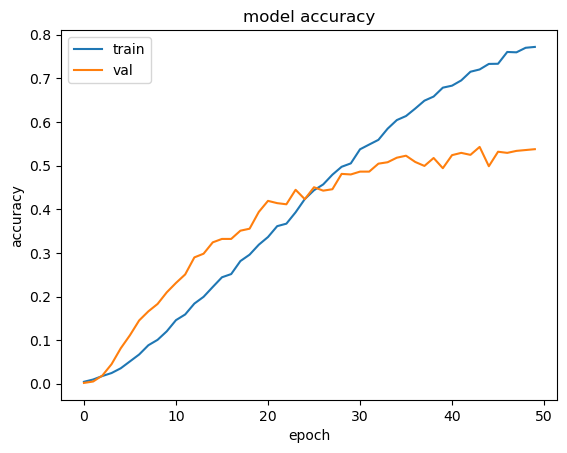

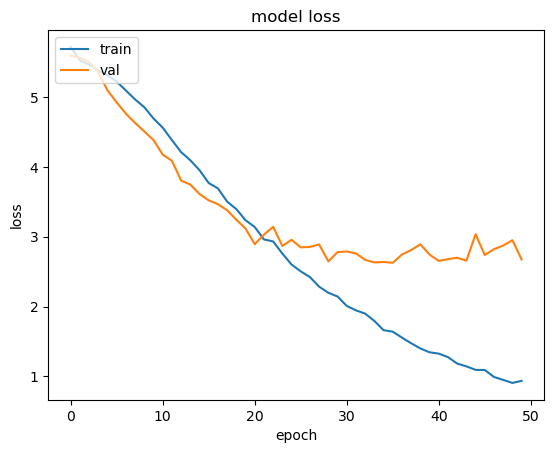

Total time spend during training is 63.43155923684438 minutes
Total time spend during testing is 2.367221959431966 minutes
Total time spend during testing is 2.3675862828890484 minutes
Accuracy during the testing : 55.09%
Loss during the testing is 2.6572054624557495
Total time for pipeline is 68.25988425811131 minutes


In [ ]:
dataset_folder = '/kaggle/input/caltech256/256_ObjectCategories'
dataset_save_folder = '/kaggle/working/caltech256'
selected_images = 30
validation_image_number = 24

input_size = (150, 150)
epoch = 50
batch_size = 32

# Generate the dataset as per the requirement
if os.path.exists(dataset_save_folder) :
    shutil.rmtree(dataset_save_folder)
generate_dataset(dataset_folder, dataset_save_folder, selected_images, validation_image_number)

training_data_set_folder = get_save_path('train', dataset_save_folder)
validation_data_set_folder = get_save_path('validation', dataset_save_folder)
testing_data_set_folder = get_save_path('test', dataset_save_folder)
execute_model(training_data_set_folder, validation_data_set_folder, testing_data_set_folder, epoch, batch_size)